### Data Challenge, Part 2

In [77]:
#!pip install catboost
#!pip install category_encoders

import pandas as pd
import numpy as np

from catboost import CatBoostClassifier, CatBoostRegressor
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, r2_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

## 1. Dataset
### 1a. Preprocessing

- After loading the provided sales data into pandas, I rounded the profit and sales columns to monetary format, and added another feature called `Ship Time`, the number of days a product took to ship, based on the `Order Date` and `Ship Date`. 
- To further simplify the dataset, I thought the following columns were worth excluding: `Country`, `City`, `Customer Name`, and `Product Name`. The only country in the dataset was United States, so `Country` does not distinguish any of the transactions. `Customer Name` and `Product Name` were also not needed, because we already have corresponding ID columns `Customer ID` and `Product ID`. Finally, I  thought `City` was not needed, since `Postal Code` basically represents the same thing and is numerical, and we also have enough geographical granularity with the `State` and `Region` columns for a 10,000 row dataset.

In [78]:
trans_df = pd.read_csv("../sales_data.csv", encoding='unicode_escape', index_col='Row ID', skipinitialspace=True)

# clean up data formats
trans_df['Profit'] = round(trans_df['Profit'], 2)
trans_df['Sales'] = round(trans_df['Sales'], 2)
trans_df['Order Date'] = pd.to_datetime(trans_df['Order Date'])
trans_df['Ship Date'] = pd.to_datetime(trans_df['Ship Date'])
trans_df['Ship Time'] = (trans_df['Ship Date'] - trans_df['Order Date']).dt.days

# drop less important columns
trans_df = trans_df.drop(columns=['Country', 'City', 'Customer Name', 'Product Name'])
print(trans_df.shape)
trans_df.head()

(9994, 17)


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit,Ship Time
Row ID,,,,,,,,,,,,,,,,,
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,261.96,2,0.00,41.91,3
2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,731.94,3,0.00,219.58,3
3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,14.62,2,0.00,6.87,4
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,957.58,5,0.45,-383.03,7
5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,22.37,2,0.20,2.52,7


### 1b. Numerical Feature Correlations

From the feature correlation matrix below, we observe the following three relationships, though none of them particularly strong:  

**Sales and Profit (+0.48)**: Not surprising, since a profitable item often has high sales. However, this correlation is weakened in the case of high-sales, high-cost items, or lower-sales, very low-cost items.

**Discount and Profit (-0.22)**: I suspected that there might be a bit of a correlation here, since often a store may have certain items on discount because they need to get rid of them quickly. Although the correlation is weak, I decided to explore this relationship further in the machine learning model to come. 

**Sales and Quantity (+0.20)**: Also not surprising that there's a hint of relationship, though there are too many examples of expensive single quantity transactions.

The `Ship Time` and `Postal Code` features did not correlate with any other numerical feature

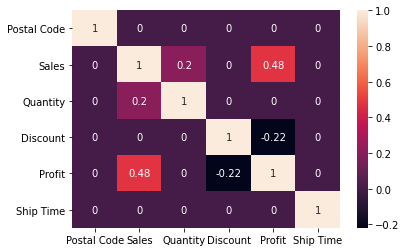

In [79]:
correlations = trans_df.corr()
correlations[np.abs(correlations) < 0.2] = 0
sns.heatmap(correlations, annot=True)
plt.show()

A negative relationship between discount and profit (-0.75) becomes apparent  when I express profit categorically, in a new feature called `Profitable`. It takes on a binary value, where 0 represents an unprofitable transaction and 1 represents a profitable one. When profit stays numerical, it probably weakens the corrrelation, since we were incorrectly imposing that a heavier discount results in a heavier loss linearly. In addition, discounts fall in a discrete range while profit is unbounded, so the constraints of these two features is different. With a `Profitable` column, a negative feedback caused by a discount is still retained, but we no longer have to assume a linear relation between the two features.

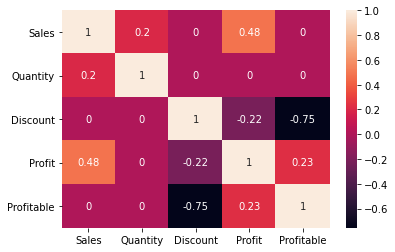

In [80]:
trans_df['Profitable'] = np.where(trans_df['Profit'] < 0, 0, 1)
correlations = trans_df.loc[:, ~trans_df.columns.isin(['Ship Time','Postal Code'])].corr()
correlations[np.abs(correlations) < 0.2] = 0
sns.heatmap(correlations, annot=True)
plt.show()

## 2. Profitability Model

With the relationship between `Discount` and `Profitable` established, I decided to train a machine learning model that predicts whether a transaction is profitable or not. 

### 2a. Base Model

For the training and testing sets, I usually stick with an 80-20 split. An interesting fact I came across is that this ratio is actually captured in the Pareto Principle, which states that about 80% of consequences come from 20% of causes. 

To train the model, I used Catboost, a gradient boosting decision tree library. In particular, I chose it over other alternatives like XGBoost and LightGBM because it has better support for categorical data. To avoid overfitting, I included another parameter `early_stopping_rounds`, which stops training the model if the validation results do not improve after a certain number of iterations. 

Using `Discount` as the only feature, here are the baseline results:  

**roc_auc score:** 0.85556  
**accuracy:** 94.35%  
821 True Unprofitable, 23 False Unprofitable, 4838 True Profitable, 314 False Profitable

In [81]:
Xb = trans_df[['Discount']]
yb = trans_df[['Profitable']]
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2)
Xb_test, Xb_val, yb_test, yb_val = train_test_split(Xb_train, yb_train, test_size=0.25)

Xb_train.shape, Xb_test.shape, yb_train.shape, yb_test.shape, Xb_val.shape, yb_val.shape

((7995, 1), (5996, 1), (7995, 1), (5996, 1), (1999, 1), (1999, 1))

In [82]:
base_model = CatBoostClassifier()
base_model.fit(Xb_train, yb_train, eval_set=(Xb_val, yb_val), early_stopping_rounds=10)

y_base_pred = base_model.predict(Xb_test)
roc_auc = roc_auc_score(yb_test, y_base_pred)
accuracy = accuracy_score(yb_test, y_base_pred)
print(f"roc_auc: {roc_auc:.5f}")
print(f"accuracy: {(accuracy*100):.2f}%")

tn, fp, fn, tp = confusion_matrix(yb_test, y_base_pred).ravel()
print(f"(True Unp, False P, False Unp, True P): {(tn, fp, fn, tp)}")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.052955
0:	learn: 0.6246117	test: 0.6241868	best: 0.6241868 (0)	total: 2.62ms	remaining: 2.62s
1:	learn: 0.5329134	test: 0.5318142	best: 0.5318142 (1)	total: 6.56ms	remaining: 3.27s
2:	learn: 0.4438977	test: 0.4423834	best: 0.4423834 (2)	total: 9.19ms	remaining: 3.06s
3:	learn: 0.3872595	test: 0.3853376	best: 0.3853376 (3)	total: 12.2ms	remaining: 3.04s
4:	learn: 0.3623427	test: 0.3598432	best: 0.3598432 (4)	total: 14.1ms	remaining: 2.81s
5:	learn: 0.3173639	test: 0.3144894	best: 0.3144894 (5)	total: 17ms	remaining: 2.81s
6:	learn: 0.2893608	test: 0.2860637	best: 0.2860637 (6)	total: 21ms	remaining: 2.98s
7:	learn: 0.2639525	test: 0.2603512	best: 0.2603512 (7)	total: 23.3ms	remaining: 2.89s
8:	learn: 0.2471231	test: 0.2431173	best: 0.2431173 (8)	total: 25.8ms	remaining: 2.83s
9:	learn: 0.2321595	test: 0.2278321	best: 0.2278321 (9)	total: 28.4ms	remaining: 2.81s
10:	learn: 0.2238094	test: 0.2192144	best: 0.2192144 (10)	total: 30.9ms	remaining: 2.77s
11:	learn: 0.21

152:	learn: 0.1654293	test: 0.1546261	best: 0.1546261 (151)	total: 347ms	remaining: 1.92s
153:	learn: 0.1654293	test: 0.1546261	best: 0.1546261 (151)	total: 349ms	remaining: 1.92s
154:	learn: 0.1654293	test: 0.1546261	best: 0.1546261 (151)	total: 351ms	remaining: 1.91s
155:	learn: 0.1654283	test: 0.1546216	best: 0.1546216 (155)	total: 352ms	remaining: 1.91s
156:	learn: 0.1654281	test: 0.1546214	best: 0.1546214 (156)	total: 357ms	remaining: 1.92s
157:	learn: 0.1654281	test: 0.1546214	best: 0.1546214 (156)	total: 359ms	remaining: 1.91s
158:	learn: 0.1654281	test: 0.1546214	best: 0.1546214 (156)	total: 361ms	remaining: 1.91s
159:	learn: 0.1654281	test: 0.1546214	best: 0.1546214 (156)	total: 362ms	remaining: 1.9s
160:	learn: 0.1654281	test: 0.1546214	best: 0.1546214 (156)	total: 365ms	remaining: 1.9s
161:	learn: 0.1654281	test: 0.1546214	best: 0.1546214 (156)	total: 372ms	remaining: 1.93s
162:	learn: 0.1654281	test: 0.1546214	best: 0.1546214 (156)	total: 374ms	remaining: 1.92s
163:	learn: 

### 2b. Revised Model

Let's take a closer look at the categorical features to see if including any of them would improve the base model.  
Before that, categorical features need to be numerically-encoded to be useful in analysis. I considered one-hot encoding, frequency encoding, and CatBoost encoding.
- One-hot encoding is not suitable for this dataset as it increases dimensionality too much. We would need 49 new columns to encode just the `State` feature, and 16 new columns for `Sub-Category` feature!
- Frequency encoding appeared to be a viable alternative, where the encoding depends on how many times a category appears in the column. However, it is problematic when multiple encodings appear the same amount of times. When this happens, the features melt together into one and we lose valuable information about the dataset. 
- Ultimately, I choose to stick with CatBoost's default encoding, which is similar to encoding categorical features based on information about the target variable. It also does not add any dimensionality to the data.

In [83]:
cat_cols = ['Ship Mode', 'Segment', 'State', 'Product ID', 'Category', 'Sub-Category', 'Region', 'Customer ID', 'Postal Code']
encoder = ce.CatBoostEncoder(cols=cat_cols)
encoder.fit(trans_df.loc[:, trans_df.columns != 'Profitable'], trans_df['Profitable'])

trans_df_enc = encoder.transform(trans_df.loc[:, trans_df.columns != 'Profitable'])
trans_df_enc['Profitable'] = trans_df['Profitable']
trans_df_enc.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit,Ship Time,Profitable
Row ID,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,2016-11-08,2016-11-11,0.842144,0.802131,0.806782,0.998663,0.996179,0.840107,0.562558,0.663437,0.523200,261.96,2,0.00,41.91,3,1
2,CA-2016-152156,2016-11-08,2016-11-11,0.842144,0.802131,0.806782,0.998663,0.996179,0.840107,0.985599,0.663437,0.619438,731.94,3,0.00,219.58,3,1
3,CA-2016-138688,2016-06-12,2016-06-16,0.842144,0.581279,0.815893,0.947459,0.965958,0.900691,0.976598,0.852964,0.999487,14.62,2,0.00,6.87,4,1
4,US-2015-108966,2015-10-11,2015-10-18,0.803453,0.800799,0.806782,0.671387,0.613299,0.840107,0.423643,0.663437,0.365040,957.58,5,0.45,-383.03,7,0
5,US-2015-108966,2015-10-11,2015-10-18,0.803453,0.800799,0.806782,0.671387,0.613299,0.840107,0.968798,0.852964,0.809696,22.37,2,0.20,2.52,7,1


Now, let's take a look a more detailed correlation matrix incorporating all the encoded categorical features and `Profitable`. Since the `Ship Mode`, `Segment`, and `Quantity` features did not have a correlation above 0.3 to any other variable, I dropped them to reduce some dimensionality. Here were some meaningful relationships not apparent before:

**Discount and State (-0.70)**: This one surprised me the most, as logically it seems that discounts should be  randomly-dispersed by state. I decided to create a model using the `Discount` feature in the following section.

Features related to `Profitable`: **Product ID and Profitable (+0.63)**, **State and Profitable (+0.52)**, and **Sub-Category and Profitable (+0.44)**  

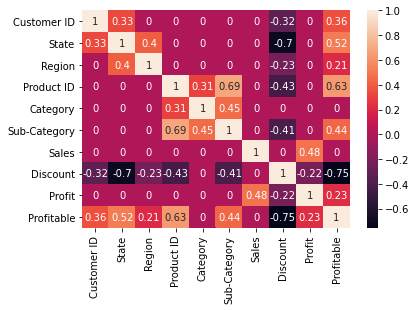

In [84]:
correlations = trans_df_enc.loc[:, ~trans_df_enc.columns.isin(['Ship Time','Postal Code', 'Ship Mode', 'Segment', 'Quantity'])].corr()
correlations[np.abs(correlations) < 0.2] = 0
sns.heatmap(correlations, annot=True)
plt.show()

`Product ID`, `State`, and `Sub-category` are all important features for us to determine profitability of a transaction. First, I only added `Product ID` to the model. The performance improved a lot, with accuracy consistently topping 99.5% and roc-auc score being almost 1. This was more than enough, since adding a third feature, `State` or `Sub-Category`, leads to no improvements and the validation results start getting worse after a smaller number of iterations, meaning that it is more prone to overfitting.

In [85]:
X_rev = trans_df[['Discount','Product ID']]
y_rev = trans_df[['Profitable']]
X_rev_train, X_rev_test, y_rev_train, y_rev_test = train_test_split(X_rev, y_rev, test_size=0.2)
X_rev_test, X_rev_val, y_rev_test, y_rev_val = train_test_split(X_rev_train, y_rev_train, test_size=0.25)

X_rev_train.shape, X_rev_test.shape, y_rev_train.shape, y_rev_test.shape, X_rev_val.shape, y_rev_val.shape

((7995, 2), (5996, 2), (7995, 1), (5996, 1), (1999, 2), (1999, 1))

In [86]:
fin_model = CatBoostClassifier() # depth=4, l2_leaf_reg=0.001, early_stopping_rounds=10
fin_model.fit(X_rev, y_rev, cat_features=['Product ID'], eval_set=(X_rev_val, y_rev_val))

y_pred = fin_model.predict(X_rev_test)
roc_auc = roc_auc_score(y_rev_test, y_pred)
accuracy = accuracy_score(y_rev_test, y_pred)
print(f"roc_auc: {roc_auc:.5f}")
print(f"accuracy: {(accuracy*100):.2f}%")

tn, fp, fn, tp = confusion_matrix(y_rev_test, y_pred).ravel()
print(f"(True Unp, False P, False Unp, True P): {(tn, fp, fn, tp)}")

Learning rate set to 0.055956
0:	learn: 0.5595502	test: 0.5613918	best: 0.5613918 (0)	total: 40.2ms	remaining: 40.2s
1:	learn: 0.4607305	test: 0.4641439	best: 0.4641439 (1)	total: 55.1ms	remaining: 27.5s
2:	learn: 0.4071664	test: 0.4117080	best: 0.4117080 (2)	total: 67.1ms	remaining: 22.3s
3:	learn: 0.3534032	test: 0.3596779	best: 0.3596779 (3)	total: 74.5ms	remaining: 18.6s
4:	learn: 0.3111195	test: 0.3186154	best: 0.3186154 (4)	total: 87.7ms	remaining: 17.5s
5:	learn: 0.2849404	test: 0.2936044	best: 0.2936044 (5)	total: 101ms	remaining: 16.8s
6:	learn: 0.2684513	test: 0.2784169	best: 0.2784169 (6)	total: 107ms	remaining: 15.1s
7:	learn: 0.2294349	test: 0.2227146	best: 0.2227146 (7)	total: 117ms	remaining: 14.6s
8:	learn: 0.2033452	test: 0.1859274	best: 0.1859274 (8)	total: 125ms	remaining: 13.8s
9:	learn: 0.1861052	test: 0.1656286	best: 0.1656286 (9)	total: 136ms	remaining: 13.4s
10:	learn: 0.1680358	test: 0.1391102	best: 0.1391102 (10)	total: 145ms	remaining: 13s
11:	learn: 0.152415

101:	learn: 0.0762282	test: 0.0087303	best: 0.0087303 (101)	total: 786ms	remaining: 6.92s
102:	learn: 0.0761763	test: 0.0086363	best: 0.0086363 (102)	total: 799ms	remaining: 6.96s
103:	learn: 0.0761031	test: 0.0085955	best: 0.0085955 (103)	total: 808ms	remaining: 6.96s
104:	learn: 0.0760423	test: 0.0085296	best: 0.0085296 (104)	total: 819ms	remaining: 6.98s
105:	learn: 0.0760330	test: 0.0085368	best: 0.0085296 (104)	total: 828ms	remaining: 6.98s
106:	learn: 0.0759455	test: 0.0085111	best: 0.0085111 (106)	total: 833ms	remaining: 6.95s
107:	learn: 0.0759455	test: 0.0085112	best: 0.0085111 (106)	total: 836ms	remaining: 6.91s
108:	learn: 0.0759455	test: 0.0085111	best: 0.0085111 (106)	total: 843ms	remaining: 6.89s
109:	learn: 0.0759247	test: 0.0085306	best: 0.0085111 (106)	total: 849ms	remaining: 6.87s
110:	learn: 0.0759247	test: 0.0085307	best: 0.0085111 (106)	total: 856ms	remaining: 6.86s
111:	learn: 0.0758520	test: 0.0084622	best: 0.0084622 (111)	total: 868ms	remaining: 6.88s
112:	learn

224:	learn: 0.0715043	test: 0.0063879	best: 0.0063876 (223)	total: 1.56s	remaining: 5.38s
225:	learn: 0.0714507	test: 0.0063109	best: 0.0063109 (225)	total: 1.57s	remaining: 5.37s
226:	learn: 0.0714145	test: 0.0062910	best: 0.0062910 (226)	total: 1.58s	remaining: 5.37s
227:	learn: 0.0713585	test: 0.0062754	best: 0.0062754 (227)	total: 1.58s	remaining: 5.37s
228:	learn: 0.0713059	test: 0.0062617	best: 0.0062617 (228)	total: 1.59s	remaining: 5.36s
229:	learn: 0.0712663	test: 0.0062457	best: 0.0062457 (229)	total: 1.6s	remaining: 5.35s
230:	learn: 0.0712371	test: 0.0062357	best: 0.0062357 (230)	total: 1.6s	remaining: 5.34s
231:	learn: 0.0712015	test: 0.0062177	best: 0.0062177 (231)	total: 1.61s	remaining: 5.32s
232:	learn: 0.0711647	test: 0.0062128	best: 0.0062128 (232)	total: 1.61s	remaining: 5.31s
233:	learn: 0.0711477	test: 0.0062190	best: 0.0062128 (232)	total: 1.62s	remaining: 5.3s
234:	learn: 0.0711261	test: 0.0062100	best: 0.0062100 (234)	total: 1.62s	remaining: 5.29s
235:	learn: 0

325:	learn: 0.0691664	test: 0.0053555	best: 0.0053533 (324)	total: 2.14s	remaining: 4.43s
326:	learn: 0.0691318	test: 0.0053473	best: 0.0053473 (326)	total: 2.15s	remaining: 4.42s
327:	learn: 0.0691260	test: 0.0053549	best: 0.0053473 (326)	total: 2.15s	remaining: 4.42s
328:	learn: 0.0691186	test: 0.0053572	best: 0.0053473 (326)	total: 2.16s	remaining: 4.41s
329:	learn: 0.0690644	test: 0.0053584	best: 0.0053473 (326)	total: 2.17s	remaining: 4.4s
330:	learn: 0.0690644	test: 0.0053584	best: 0.0053473 (326)	total: 2.17s	remaining: 4.39s
331:	learn: 0.0690447	test: 0.0053692	best: 0.0053473 (326)	total: 2.17s	remaining: 4.38s
332:	learn: 0.0690447	test: 0.0053692	best: 0.0053473 (326)	total: 2.18s	remaining: 4.37s
333:	learn: 0.0690447	test: 0.0053692	best: 0.0053473 (326)	total: 2.18s	remaining: 4.36s
334:	learn: 0.0690447	test: 0.0053692	best: 0.0053473 (326)	total: 2.19s	remaining: 4.34s
335:	learn: 0.0690447	test: 0.0053692	best: 0.0053473 (326)	total: 2.19s	remaining: 4.33s
336:	learn:

427:	learn: 0.0683172	test: 0.0052869	best: 0.0052771 (398)	total: 2.73s	remaining: 3.64s
428:	learn: 0.0683172	test: 0.0052869	best: 0.0052771 (398)	total: 2.73s	remaining: 3.64s
429:	learn: 0.0683172	test: 0.0052869	best: 0.0052771 (398)	total: 2.74s	remaining: 3.63s
430:	learn: 0.0683172	test: 0.0052869	best: 0.0052771 (398)	total: 2.75s	remaining: 3.63s
431:	learn: 0.0683172	test: 0.0052869	best: 0.0052771 (398)	total: 2.75s	remaining: 3.62s
432:	learn: 0.0683093	test: 0.0052879	best: 0.0052771 (398)	total: 2.76s	remaining: 3.61s
433:	learn: 0.0683093	test: 0.0052879	best: 0.0052771 (398)	total: 2.76s	remaining: 3.6s
434:	learn: 0.0683002	test: 0.0052856	best: 0.0052771 (398)	total: 2.77s	remaining: 3.6s
435:	learn: 0.0683002	test: 0.0052856	best: 0.0052771 (398)	total: 2.78s	remaining: 3.59s
436:	learn: 0.0683002	test: 0.0052856	best: 0.0052771 (398)	total: 2.78s	remaining: 3.59s
437:	learn: 0.0683002	test: 0.0052856	best: 0.0052771 (398)	total: 2.79s	remaining: 3.58s
438:	learn: 

524:	learn: 0.0672990	test: 0.0051729	best: 0.0051612 (518)	total: 3.31s	remaining: 2.99s
525:	learn: 0.0672990	test: 0.0051729	best: 0.0051612 (518)	total: 3.32s	remaining: 2.99s
526:	learn: 0.0672990	test: 0.0051730	best: 0.0051612 (518)	total: 3.33s	remaining: 2.98s
527:	learn: 0.0672796	test: 0.0051857	best: 0.0051612 (518)	total: 3.33s	remaining: 2.98s
528:	learn: 0.0672796	test: 0.0051857	best: 0.0051612 (518)	total: 3.34s	remaining: 2.97s
529:	learn: 0.0672602	test: 0.0051787	best: 0.0051612 (518)	total: 3.35s	remaining: 2.97s
530:	learn: 0.0672602	test: 0.0051787	best: 0.0051612 (518)	total: 3.35s	remaining: 2.96s
531:	learn: 0.0672602	test: 0.0051787	best: 0.0051612 (518)	total: 3.36s	remaining: 2.96s
532:	learn: 0.0672602	test: 0.0051787	best: 0.0051612 (518)	total: 3.37s	remaining: 2.95s
533:	learn: 0.0672564	test: 0.0051765	best: 0.0051612 (518)	total: 3.37s	remaining: 2.94s
534:	learn: 0.0672386	test: 0.0051699	best: 0.0051612 (518)	total: 3.38s	remaining: 2.94s
535:	learn

635:	learn: 0.0665373	test: 0.0051268	best: 0.0051268 (635)	total: 3.9s	remaining: 2.23s
636:	learn: 0.0665373	test: 0.0051268	best: 0.0051268 (636)	total: 3.91s	remaining: 2.23s
637:	learn: 0.0665373	test: 0.0051268	best: 0.0051268 (637)	total: 3.92s	remaining: 2.22s
638:	learn: 0.0665373	test: 0.0051268	best: 0.0051268 (638)	total: 3.92s	remaining: 2.21s
639:	learn: 0.0665372	test: 0.0051267	best: 0.0051267 (639)	total: 3.92s	remaining: 2.21s
640:	learn: 0.0665361	test: 0.0051265	best: 0.0051265 (640)	total: 3.93s	remaining: 2.2s
641:	learn: 0.0665361	test: 0.0051265	best: 0.0051265 (641)	total: 3.94s	remaining: 2.19s
642:	learn: 0.0665361	test: 0.0051265	best: 0.0051265 (642)	total: 3.94s	remaining: 2.19s
643:	learn: 0.0665360	test: 0.0051265	best: 0.0051265 (643)	total: 3.95s	remaining: 2.18s
644:	learn: 0.0665358	test: 0.0051261	best: 0.0051261 (644)	total: 3.95s	remaining: 2.18s
645:	learn: 0.0665357	test: 0.0051259	best: 0.0051259 (645)	total: 3.96s	remaining: 2.17s
646:	learn: 

739:	learn: 0.0664597	test: 0.0051104	best: 0.0051104 (739)	total: 4.48s	remaining: 1.57s
740:	learn: 0.0664597	test: 0.0051104	best: 0.0051104 (740)	total: 4.49s	remaining: 1.57s
741:	learn: 0.0664597	test: 0.0051104	best: 0.0051104 (741)	total: 4.49s	remaining: 1.56s
742:	learn: 0.0664596	test: 0.0051104	best: 0.0051104 (742)	total: 4.5s	remaining: 1.56s
743:	learn: 0.0664596	test: 0.0051104	best: 0.0051104 (743)	total: 4.5s	remaining: 1.55s
744:	learn: 0.0664596	test: 0.0051104	best: 0.0051104 (744)	total: 4.51s	remaining: 1.54s
745:	learn: 0.0664596	test: 0.0051104	best: 0.0051104 (745)	total: 4.52s	remaining: 1.54s
746:	learn: 0.0664596	test: 0.0051104	best: 0.0051104 (746)	total: 4.53s	remaining: 1.53s
747:	learn: 0.0664596	test: 0.0051104	best: 0.0051104 (747)	total: 4.54s	remaining: 1.53s
748:	learn: 0.0664596	test: 0.0051103	best: 0.0051103 (748)	total: 4.54s	remaining: 1.52s
749:	learn: 0.0664596	test: 0.0051103	best: 0.0051103 (749)	total: 4.55s	remaining: 1.51s
750:	learn: 

831:	learn: 0.0658808	test: 0.0050404	best: 0.0050348 (820)	total: 5.07s	remaining: 1.02s
832:	learn: 0.0658808	test: 0.0050403	best: 0.0050348 (820)	total: 5.08s	remaining: 1.02s
833:	learn: 0.0658625	test: 0.0050338	best: 0.0050338 (833)	total: 5.09s	remaining: 1.01s
834:	learn: 0.0658348	test: 0.0050095	best: 0.0050095 (834)	total: 5.1s	remaining: 1.01s
835:	learn: 0.0658030	test: 0.0049812	best: 0.0049812 (835)	total: 5.11s	remaining: 1s
836:	learn: 0.0657679	test: 0.0049736	best: 0.0049736 (836)	total: 5.12s	remaining: 997ms
837:	learn: 0.0657679	test: 0.0049736	best: 0.0049736 (836)	total: 5.12s	remaining: 990ms
838:	learn: 0.0657679	test: 0.0049736	best: 0.0049736 (836)	total: 5.13s	remaining: 984ms
839:	learn: 0.0657550	test: 0.0049742	best: 0.0049736 (836)	total: 5.13s	remaining: 978ms
840:	learn: 0.0657550	test: 0.0049742	best: 0.0049736 (836)	total: 5.14s	remaining: 971ms
841:	learn: 0.0657550	test: 0.0049742	best: 0.0049736 (836)	total: 5.14s	remaining: 965ms
842:	learn: 0.

931:	learn: 0.0647294	test: 0.0047172	best: 0.0047048 (910)	total: 5.66s	remaining: 413ms
932:	learn: 0.0647294	test: 0.0047172	best: 0.0047048 (910)	total: 5.66s	remaining: 407ms
933:	learn: 0.0647294	test: 0.0047172	best: 0.0047048 (910)	total: 5.67s	remaining: 400ms
934:	learn: 0.0647062	test: 0.0047161	best: 0.0047048 (910)	total: 5.67s	remaining: 394ms
935:	learn: 0.0646538	test: 0.0047085	best: 0.0047048 (910)	total: 5.68s	remaining: 389ms
936:	learn: 0.0646538	test: 0.0047085	best: 0.0047048 (910)	total: 5.69s	remaining: 382ms
937:	learn: 0.0646324	test: 0.0047077	best: 0.0047048 (910)	total: 5.69s	remaining: 376ms
938:	learn: 0.0646324	test: 0.0047077	best: 0.0047048 (910)	total: 5.7s	remaining: 370ms
939:	learn: 0.0646324	test: 0.0047077	best: 0.0047048 (910)	total: 5.7s	remaining: 364ms
940:	learn: 0.0646028	test: 0.0047030	best: 0.0047030 (940)	total: 5.71s	remaining: 358ms
941:	learn: 0.0645949	test: 0.0047013	best: 0.0047013 (941)	total: 5.71s	remaining: 352ms
942:	learn: 

## 3. Discount Model

Seeing that the transaction discount correlated to many other features in the dataset, I decided to create a regression model that would predict the amount of discount applied on a given transaction. By simply using the features with highest correlation to `Discount` from the matrix, the model outputs nearly perfect predictions. 

**r-squared:** 0.9933, **rmse:** 0.0003

In [104]:
X_disc = trans_df[['Profitable','Sub-Category', 'State']]
y_disc = trans_df[['Discount']]
X_disc_train, X_disc_test, y_disc_train, y_disc_test = train_test_split(X_disc, y_disc, test_size=0.2)
X_disc_test, X_disc_val, y_disc_test, y_disc_val = train_test_split(X_disc_train, y_disc_train, test_size=0.25)

X_disc_train.shape, X_disc_test.shape, y_disc_train.shape, y_disc_test.shape

((7995, 3), (5996, 3), (7995, 1), (5996, 1))

In [105]:
disc_model = CatBoostRegressor(n_estimators=1500, depth=4, l2_leaf_reg=0.001, early_stopping_rounds=10)
disc_model.fit(X_disc, y_disc, eval_set=(X_disc_val, y_disc_val), cat_features=['Sub-Category', 'State'])

y_disc_pred = np.round(disc_model.predict(X_disc_test), 2)
r2 = r2_score(y_disc_test, y_disc_pred)
rmse = mean_squared_error(y_disc_test, y_disc_pred)
print(f"r^2: {r2:.4f}")
print(f"rmse: {rmse:.4f}")

0:	learn: 0.2012526	test: 0.2000256	best: 0.2000256 (0)	total: 5.8ms	remaining: 8.7s
1:	learn: 0.1963309	test: 0.1951124	best: 0.1951124 (1)	total: 8.97ms	remaining: 6.72s
2:	learn: 0.1914947	test: 0.1902985	best: 0.1902985 (2)	total: 11.5ms	remaining: 5.73s
3:	learn: 0.1866898	test: 0.1854879	best: 0.1854879 (3)	total: 14.3ms	remaining: 5.36s
4:	learn: 0.1822342	test: 0.1810506	best: 0.1810506 (4)	total: 17.7ms	remaining: 5.28s
5:	learn: 0.1776906	test: 0.1764756	best: 0.1764756 (5)	total: 20.7ms	remaining: 5.16s
6:	learn: 0.1733608	test: 0.1721270	best: 0.1721270 (6)	total: 23.4ms	remaining: 5s
7:	learn: 0.1691993	test: 0.1679561	best: 0.1679561 (7)	total: 26ms	remaining: 4.86s
8:	learn: 0.1651985	test: 0.1639091	best: 0.1639091 (8)	total: 30.1ms	remaining: 4.98s
9:	learn: 0.1613604	test: 0.1600545	best: 0.1600545 (9)	total: 33ms	remaining: 4.92s
10:	learn: 0.1576322	test: 0.1563093	best: 0.1563093 (10)	total: 35.6ms	remaining: 4.82s
11:	learn: 0.1541495	test: 0.1527534	best: 0.15275

139:	learn: 0.0466989	test: 0.0444172	best: 0.0444172 (139)	total: 378ms	remaining: 3.67s
140:	learn: 0.0466163	test: 0.0443287	best: 0.0443287 (140)	total: 381ms	remaining: 3.67s
141:	learn: 0.0463443	test: 0.0440593	best: 0.0440593 (141)	total: 385ms	remaining: 3.68s
142:	learn: 0.0461600	test: 0.0438976	best: 0.0438976 (142)	total: 388ms	remaining: 3.68s
143:	learn: 0.0458953	test: 0.0436536	best: 0.0436536 (143)	total: 392ms	remaining: 3.69s
144:	learn: 0.0456437	test: 0.0434455	best: 0.0434455 (144)	total: 403ms	remaining: 3.77s
145:	learn: 0.0454134	test: 0.0432126	best: 0.0432126 (145)	total: 409ms	remaining: 3.79s
146:	learn: 0.0453238	test: 0.0431110	best: 0.0431110 (146)	total: 415ms	remaining: 3.82s
147:	learn: 0.0452497	test: 0.0430250	best: 0.0430250 (147)	total: 418ms	remaining: 3.81s
148:	learn: 0.0450606	test: 0.0428485	best: 0.0428485 (148)	total: 421ms	remaining: 3.81s
149:	learn: 0.0449021	test: 0.0426969	best: 0.0426969 (149)	total: 424ms	remaining: 3.81s
150:	learn

260:	learn: 0.0360654	test: 0.0335673	best: 0.0335673 (260)	total: 742ms	remaining: 3.52s
261:	learn: 0.0360438	test: 0.0335415	best: 0.0335415 (261)	total: 748ms	remaining: 3.54s
262:	learn: 0.0360294	test: 0.0335356	best: 0.0335356 (262)	total: 751ms	remaining: 3.53s
263:	learn: 0.0360128	test: 0.0335129	best: 0.0335129 (263)	total: 755ms	remaining: 3.53s
264:	learn: 0.0359774	test: 0.0334729	best: 0.0334729 (264)	total: 760ms	remaining: 3.54s
265:	learn: 0.0359638	test: 0.0334653	best: 0.0334653 (265)	total: 765ms	remaining: 3.55s
266:	learn: 0.0358932	test: 0.0334088	best: 0.0334088 (266)	total: 769ms	remaining: 3.55s
267:	learn: 0.0357990	test: 0.0333014	best: 0.0333014 (267)	total: 773ms	remaining: 3.56s
268:	learn: 0.0357590	test: 0.0332553	best: 0.0332553 (268)	total: 777ms	remaining: 3.55s
269:	learn: 0.0356238	test: 0.0331261	best: 0.0331261 (269)	total: 780ms	remaining: 3.55s
270:	learn: 0.0355941	test: 0.0330830	best: 0.0330830 (270)	total: 784ms	remaining: 3.55s
271:	learn

367:	learn: 0.0321299	test: 0.0295305	best: 0.0295305 (367)	total: 1.1s	remaining: 3.4s
368:	learn: 0.0320672	test: 0.0294542	best: 0.0294542 (368)	total: 1.11s	remaining: 3.41s
369:	learn: 0.0320604	test: 0.0294488	best: 0.0294488 (369)	total: 1.11s	remaining: 3.41s
370:	learn: 0.0320036	test: 0.0293851	best: 0.0293851 (370)	total: 1.12s	remaining: 3.4s
371:	learn: 0.0319232	test: 0.0293023	best: 0.0293023 (371)	total: 1.13s	remaining: 3.41s
372:	learn: 0.0319008	test: 0.0292753	best: 0.0292753 (372)	total: 1.13s	remaining: 3.41s
373:	learn: 0.0318249	test: 0.0291969	best: 0.0291969 (373)	total: 1.13s	remaining: 3.41s
374:	learn: 0.0318062	test: 0.0291813	best: 0.0291813 (374)	total: 1.13s	remaining: 3.4s
375:	learn: 0.0317687	test: 0.0291393	best: 0.0291393 (375)	total: 1.14s	remaining: 3.4s
376:	learn: 0.0317646	test: 0.0291372	best: 0.0291372 (376)	total: 1.14s	remaining: 3.4s
377:	learn: 0.0317564	test: 0.0291247	best: 0.0291247 (377)	total: 1.14s	remaining: 3.4s
378:	learn: 0.031

489:	learn: 0.0289845	test: 0.0261963	best: 0.0261963 (489)	total: 1.47s	remaining: 3.02s
490:	learn: 0.0289783	test: 0.0261943	best: 0.0261943 (490)	total: 1.47s	remaining: 3.02s
491:	learn: 0.0289574	test: 0.0261694	best: 0.0261694 (491)	total: 1.47s	remaining: 3.01s
492:	learn: 0.0289536	test: 0.0261669	best: 0.0261669 (492)	total: 1.47s	remaining: 3.01s
493:	learn: 0.0289339	test: 0.0261443	best: 0.0261443 (493)	total: 1.48s	remaining: 3.01s
494:	learn: 0.0289245	test: 0.0261386	best: 0.0261386 (494)	total: 1.48s	remaining: 3.01s
495:	learn: 0.0289053	test: 0.0261158	best: 0.0261158 (495)	total: 1.48s	remaining: 3s
496:	learn: 0.0289033	test: 0.0261145	best: 0.0261145 (496)	total: 1.49s	remaining: 3s
497:	learn: 0.0288610	test: 0.0260719	best: 0.0260719 (497)	total: 1.49s	remaining: 2.99s
498:	learn: 0.0288425	test: 0.0260474	best: 0.0260474 (498)	total: 1.49s	remaining: 3s
499:	learn: 0.0288139	test: 0.0260210	best: 0.0260210 (499)	total: 1.5s	remaining: 2.99s
500:	learn: 0.028805

614:	learn: 0.0271265	test: 0.0243279	best: 0.0243279 (614)	total: 1.82s	remaining: 2.62s
615:	learn: 0.0271229	test: 0.0243276	best: 0.0243276 (615)	total: 1.82s	remaining: 2.62s
616:	learn: 0.0271116	test: 0.0243242	best: 0.0243242 (616)	total: 1.83s	remaining: 2.62s
617:	learn: 0.0271021	test: 0.0243179	best: 0.0243179 (617)	total: 1.83s	remaining: 2.62s
618:	learn: 0.0271000	test: 0.0243162	best: 0.0243162 (618)	total: 1.83s	remaining: 2.61s
619:	learn: 0.0270883	test: 0.0243088	best: 0.0243088 (619)	total: 1.84s	remaining: 2.61s
620:	learn: 0.0270681	test: 0.0242205	best: 0.0242205 (620)	total: 1.84s	remaining: 2.61s
621:	learn: 0.0270312	test: 0.0241798	best: 0.0241798 (621)	total: 1.85s	remaining: 2.61s
622:	learn: 0.0270159	test: 0.0241651	best: 0.0241651 (622)	total: 1.85s	remaining: 2.6s
623:	learn: 0.0270126	test: 0.0241648	best: 0.0241648 (623)	total: 1.85s	remaining: 2.6s
624:	learn: 0.0270073	test: 0.0241547	best: 0.0241547 (624)	total: 1.85s	remaining: 2.6s
625:	learn: 0

721:	learn: 0.0259286	test: 0.0231051	best: 0.0231051 (721)	total: 2.16s	remaining: 2.33s
722:	learn: 0.0259251	test: 0.0231043	best: 0.0231043 (722)	total: 2.17s	remaining: 2.33s
723:	learn: 0.0259189	test: 0.0230986	best: 0.0230986 (723)	total: 2.17s	remaining: 2.33s
724:	learn: 0.0259169	test: 0.0230976	best: 0.0230976 (724)	total: 2.17s	remaining: 2.32s
725:	learn: 0.0259122	test: 0.0230936	best: 0.0230936 (725)	total: 2.18s	remaining: 2.32s
726:	learn: 0.0259059	test: 0.0230926	best: 0.0230926 (726)	total: 2.18s	remaining: 2.32s
727:	learn: 0.0258938	test: 0.0230925	best: 0.0230925 (727)	total: 2.19s	remaining: 2.32s
728:	learn: 0.0258769	test: 0.0230788	best: 0.0230788 (728)	total: 2.19s	remaining: 2.31s
729:	learn: 0.0258689	test: 0.0230701	best: 0.0230701 (729)	total: 2.19s	remaining: 2.31s
730:	learn: 0.0258652	test: 0.0230688	best: 0.0230688 (730)	total: 2.19s	remaining: 2.31s
731:	learn: 0.0258550	test: 0.0230642	best: 0.0230642 (731)	total: 2.2s	remaining: 2.31s
732:	learn:

849:	learn: 0.0250671	test: 0.0221809	best: 0.0221809 (849)	total: 2.53s	remaining: 1.93s
850:	learn: 0.0250472	test: 0.0221584	best: 0.0221584 (850)	total: 2.53s	remaining: 1.93s
851:	learn: 0.0250450	test: 0.0221574	best: 0.0221574 (851)	total: 2.53s	remaining: 1.93s
852:	learn: 0.0250353	test: 0.0221446	best: 0.0221446 (852)	total: 2.54s	remaining: 1.92s
853:	learn: 0.0250299	test: 0.0221378	best: 0.0221378 (853)	total: 2.54s	remaining: 1.92s
854:	learn: 0.0250250	test: 0.0221363	best: 0.0221363 (854)	total: 2.54s	remaining: 1.92s
855:	learn: 0.0250207	test: 0.0221354	best: 0.0221354 (855)	total: 2.54s	remaining: 1.91s
856:	learn: 0.0250151	test: 0.0221273	best: 0.0221273 (856)	total: 2.55s	remaining: 1.91s
857:	learn: 0.0249787	test: 0.0220866	best: 0.0220866 (857)	total: 2.55s	remaining: 1.91s
858:	learn: 0.0249680	test: 0.0220769	best: 0.0220769 (858)	total: 2.56s	remaining: 1.91s
859:	learn: 0.0249579	test: 0.0220679	best: 0.0220679 (859)	total: 2.56s	remaining: 1.91s
860:	learn

967:	learn: 0.0240551	test: 0.0211929	best: 0.0211927 (966)	total: 2.9s	remaining: 1.59s
968:	learn: 0.0240505	test: 0.0211924	best: 0.0211924 (968)	total: 2.9s	remaining: 1.59s
969:	learn: 0.0240477	test: 0.0211912	best: 0.0211912 (969)	total: 2.91s	remaining: 1.59s
970:	learn: 0.0240421	test: 0.0211850	best: 0.0211850 (970)	total: 2.91s	remaining: 1.59s
971:	learn: 0.0240407	test: 0.0211840	best: 0.0211840 (971)	total: 2.91s	remaining: 1.58s
972:	learn: 0.0240346	test: 0.0211784	best: 0.0211784 (972)	total: 2.92s	remaining: 1.58s
973:	learn: 0.0240294	test: 0.0211786	best: 0.0211784 (972)	total: 2.92s	remaining: 1.58s
974:	learn: 0.0240247	test: 0.0211758	best: 0.0211758 (974)	total: 2.92s	remaining: 1.57s
975:	learn: 0.0240210	test: 0.0211751	best: 0.0211751 (975)	total: 2.93s	remaining: 1.57s
976:	learn: 0.0240189	test: 0.0211751	best: 0.0211751 (975)	total: 2.93s	remaining: 1.57s
977:	learn: 0.0240169	test: 0.0211751	best: 0.0211751 (975)	total: 2.93s	remaining: 1.56s
978:	learn: 

1095:	learn: 0.0229893	test: 0.0202276	best: 0.0202276 (1095)	total: 3.26s	remaining: 1.2s
1096:	learn: 0.0229841	test: 0.0202240	best: 0.0202240 (1096)	total: 3.27s	remaining: 1.2s
1097:	learn: 0.0229809	test: 0.0202211	best: 0.0202211 (1097)	total: 3.27s	remaining: 1.2s
1098:	learn: 0.0229790	test: 0.0202209	best: 0.0202209 (1098)	total: 3.27s	remaining: 1.19s
1099:	learn: 0.0229780	test: 0.0202204	best: 0.0202204 (1099)	total: 3.27s	remaining: 1.19s
1100:	learn: 0.0229778	test: 0.0202202	best: 0.0202202 (1100)	total: 3.28s	remaining: 1.19s
1101:	learn: 0.0229757	test: 0.0202206	best: 0.0202202 (1100)	total: 3.28s	remaining: 1.19s
1102:	learn: 0.0229737	test: 0.0202201	best: 0.0202201 (1102)	total: 3.29s	remaining: 1.18s
1103:	learn: 0.0229735	test: 0.0202200	best: 0.0202200 (1103)	total: 3.29s	remaining: 1.18s
1104:	learn: 0.0229673	test: 0.0202148	best: 0.0202148 (1104)	total: 3.29s	remaining: 1.18s
1105:	learn: 0.0229430	test: 0.0201875	best: 0.0201875 (1105)	total: 3.3s	remaining

1213:	learn: 0.0223107	test: 0.0195650	best: 0.0195650 (1213)	total: 3.63s	remaining: 855ms
1214:	learn: 0.0223078	test: 0.0195652	best: 0.0195650 (1213)	total: 3.63s	remaining: 852ms
1215:	learn: 0.0223030	test: 0.0195587	best: 0.0195587 (1215)	total: 3.63s	remaining: 849ms
1216:	learn: 0.0223012	test: 0.0195592	best: 0.0195587 (1215)	total: 3.64s	remaining: 846ms
1217:	learn: 0.0222942	test: 0.0195549	best: 0.0195549 (1217)	total: 3.64s	remaining: 843ms
1218:	learn: 0.0222911	test: 0.0195537	best: 0.0195537 (1218)	total: 3.64s	remaining: 840ms
1219:	learn: 0.0222885	test: 0.0195527	best: 0.0195527 (1219)	total: 3.65s	remaining: 837ms
1220:	learn: 0.0222850	test: 0.0195532	best: 0.0195527 (1219)	total: 3.65s	remaining: 834ms
1221:	learn: 0.0222841	test: 0.0195528	best: 0.0195527 (1219)	total: 3.65s	remaining: 832ms
1222:	learn: 0.0222832	test: 0.0195510	best: 0.0195510 (1222)	total: 3.66s	remaining: 829ms
1223:	learn: 0.0222825	test: 0.0195501	best: 0.0195501 (1223)	total: 3.66s	remai

1335:	learn: 0.0218753	test: 0.0191518	best: 0.0191518 (1335)	total: 4s	remaining: 491ms
1336:	learn: 0.0218714	test: 0.0191479	best: 0.0191479 (1336)	total: 4.01s	remaining: 489ms
1337:	learn: 0.0218711	test: 0.0191474	best: 0.0191474 (1337)	total: 4.01s	remaining: 485ms
1338:	learn: 0.0218646	test: 0.0191440	best: 0.0191440 (1338)	total: 4.01s	remaining: 483ms
1339:	learn: 0.0218634	test: 0.0191444	best: 0.0191440 (1338)	total: 4.02s	remaining: 480ms
1340:	learn: 0.0218490	test: 0.0191431	best: 0.0191431 (1340)	total: 4.02s	remaining: 477ms
1341:	learn: 0.0218480	test: 0.0191422	best: 0.0191422 (1341)	total: 4.02s	remaining: 474ms
1342:	learn: 0.0218345	test: 0.0191411	best: 0.0191411 (1342)	total: 4.03s	remaining: 471ms
1343:	learn: 0.0218330	test: 0.0191411	best: 0.0191411 (1343)	total: 4.03s	remaining: 468ms
1344:	learn: 0.0218282	test: 0.0191355	best: 0.0191355 (1344)	total: 4.03s	remaining: 465ms
1345:	learn: 0.0218245	test: 0.0191356	best: 0.0191355 (1344)	total: 4.04s	remainin

1449:	learn: 0.0210932	test: 0.0185822	best: 0.0185801 (1448)	total: 4.34s	remaining: 150ms
1450:	learn: 0.0210829	test: 0.0185655	best: 0.0185655 (1450)	total: 4.34s	remaining: 147ms
1451:	learn: 0.0210810	test: 0.0185659	best: 0.0185655 (1450)	total: 4.34s	remaining: 144ms
1452:	learn: 0.0210713	test: 0.0185499	best: 0.0185499 (1452)	total: 4.34s	remaining: 140ms
1453:	learn: 0.0210658	test: 0.0185425	best: 0.0185425 (1453)	total: 4.35s	remaining: 138ms
1454:	learn: 0.0210508	test: 0.0185410	best: 0.0185410 (1454)	total: 4.35s	remaining: 135ms
1455:	learn: 0.0210460	test: 0.0185357	best: 0.0185357 (1455)	total: 4.35s	remaining: 132ms
1456:	learn: 0.0210445	test: 0.0185347	best: 0.0185347 (1456)	total: 4.36s	remaining: 129ms
1457:	learn: 0.0210401	test: 0.0185298	best: 0.0185298 (1457)	total: 4.36s	remaining: 126ms
1458:	learn: 0.0210352	test: 0.0185214	best: 0.0185214 (1458)	total: 4.36s	remaining: 123ms
1459:	learn: 0.0210341	test: 0.0185206	best: 0.0185206 (1459)	total: 4.37s	remai

### 4. Sub-Category Model

### 4a. Base Model
The final model I designed was one that could predict an transaction's sub-category. I first referred to the correlation matrix created above, which shows that the `Discount` and `Profitable` columns have a stronger correlation to `Sub-Category`. However, the model had an accuracy less than 30%. The relationship between the features and the target is more complex and non-linear, so the correlation matrix is misleading here. 

Instead, I decided to intuitively pick the features. I strived to pick the least amount of columns to make the predictions, so that the model does not overfit and is generalizable to unseen transactions. There are some obvious categories that would defeat the purpose of this model, like `Product ID` and `Category`, so I could eliminate those columns right away. 

This leaves us with the following features: `Profit`, `Profitable`, `State`, `Region`, `Postal Code`, `Ship Time`, `Segment`, `Ship Mode`, `Customer ID`, `Sales`, `Quantity`, and `Discount`. Here were some of my considerations: 

(1) Choose `Profit` or `Profitable`, as we only need one feature that gives profit information. 

(2) `State`, `Region`, and `Postal Code` encode very similar information, so I decided it would be best to include the one of these three that improved the model the most. 

(3) `Ship Time`, `Segment`, `Ship Mode`, and `Customer ID` were the least correlated in the matrix, but I decided to include one of these four for completeness.

(4) `Sales`, `Quantity`, and `Discount` were more up in the air, though I was learning towards including `Sales` or `Quantity` (or both) more

Here are my base model results:

**Features:** `State`, `Profitable`, `Sales`, `Segment` | **Accuracy: 28.75%**

### 4b. Modification 1
To resolve Consideration (1), I replaced `Profitable` with `Profit`, a sizeable improvement: 

**Features:** `State`, `Profit`, `Sales`, `Segment` | **Accuracy: 50.55%**

### 4c. Modification 2

Next, to resolve Consideration (2), I replaced `State` with `Postal Code` to see if some more granularity in geographical information would help the model.

**Features:** `Postal Code`, `Profit`, `Sales`, `Segment` | **Accuracy: 57.32%**

### 4d. Modification 3

Now, for consideration (3), I replaced `Segment` with `Ship Time`, `Ship Mode`, or `Customer ID`. We see that `Ship Time` results in the best accuracy, and that `Ship Mode` and `Customer ID` actually hurt the model: 

<mark>**Features:** `Postal Code`, `Profit`, `Sales`, `Ship Time` | **Accuracy: 69.00%**</mark>

**Features:** `Postal Code`, `Profit`, `Sales` | **Accuracy: 66.11%**

**Features:** `Postal Code`, `Profit`, `Sales`, `Ship Mode` | **Accuracy: 59.32%**

**Features:** `Postal Code`, `Profit`, `Sales`, `Customer ID` | **Accuracy: 51.15%**

### 4e. Modification 4

Finally, below are the results for consideration (4), between the `Sales`, `Quantity`, and `Discount` features. The `Sales` feature is the most important of the three, and the accuracy receives a further boost with either `Quantity` or `Discount` as an additional feature. 

<mark>**Features:** `Postal Code`, `Profit`, `Sales`, `Quantity`, `Ship Time` | **Accuracy: 77.35%**<mark>

**Features:** `Postal Code`, `Profit`, `Sales`, `Discount`, `Ship Time` | **Accuracy: 76.92%**

**Features:** `Postal Code`, `Profit`, `Quantity`, `Discount`, `Ship Time` | **Accuracy: 69.80%**

**Features:** `Postal Code`, `Profit`, `Sales`, `Ship Time` | **Accuracy: 69.00%**

### 4f. Hyperparameter Tuning

I decided to do some hyperparameter tuning on the best feature configuration to see how much I could bump up the accuracy. The following setup below employs an exhaustive grid search on the `depth`, `learning_rate`, and`l2_leaf_reg` parameters in Catboost. These parameters were recommended in their documentation to improve training convergence and stability. 

In [91]:
# hyperparameter grid search 
tuning = False

if tuning:
    params = {
        'depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'l2_leaf_reg': [0.0001, 0.001]
    }

    model_grid = GridSearchCV(estimator=CatBoostClassifier(), param_grid=params, scoring='accuracy')
    model_grid.fit(X_subc_train, y_subc_train, eval_set=(X_subc_val, y_subc_val), cat_features=['Category'], early_stopping_rounds=10)

    print("Results from Grid Search")
    print(f"The best estimator across search space: {model_grid.best_estimator_}")
    print(f"The best score across search space: {model_grid.best_score_}")
    print(f"The best params across search space: {model_grid.best_params_}")

Before hyper-parameter tuning: `depth=3, learning_rate=0.113064, l2_leaf_reg=3`

**Features:** `Postal Code`, `Profit`, `Sales`, `Quantity`, `Ship Time` | **Accuracy: 77.35%**
    
After hyper-parameter tuning: `depth=7, learning_rate=0.2, l2_leaf_reg=0.001`

<mark> **Features:** `Postal Code`, `Profit`, `Sales`, `Quantity`, `Ship Time` | **Accuracy: 99.62%** <mark>

In [95]:
X_subc = trans_df[['Postal Code', 'Profit', 'Quantity', 'Discount', 'Ship Time']]
y_subc = trans_df[['Sub-Category']]

X_subc_train, X_subc_test, y_subc_train, y_subc_test = train_test_split(X_subc, y_subc, test_size=0.2)
X_subc_test, X_subc_val, y_subc_test, y_subc_val = train_test_split(X_subc_train, y_subc_train, test_size=0.25)

X_subc_train.shape, X_subc_test.shape, y_subc_train.shape, y_subc_test.shape

((7995, 5), (5996, 5), (7995, 1), (5996, 1))

In [99]:
subc_model = CatBoostClassifier(n_estimators=1000, depth=7, l2_leaf_reg=0.001, learning_rate=0.2, early_stopping_rounds=10)
subc_model.fit(X_subc, y_subc, eval_set=(X_subc_val, y_subc_val))

y_subc_pred = subc_model.predict(X_subc_test)
accuracy = accuracy_score(np.array(y_subc_test), np.array(y_subc_pred))
print(f"accuracy: {(accuracy*100):.2f}%")

0:	learn: 2.4920271	test: 2.4680408	best: 2.4680408 (0)	total: 28.8ms	remaining: 28.7s
1:	learn: 2.2715115	test: 2.2362996	best: 2.2362996 (1)	total: 51.9ms	remaining: 25.9s
2:	learn: 2.1695192	test: 2.1352778	best: 2.1352778 (2)	total: 76.8ms	remaining: 25.5s
3:	learn: 2.1265067	test: 2.0896350	best: 2.0896350 (3)	total: 93.6ms	remaining: 23.3s
4:	learn: 2.0764280	test: 2.0403223	best: 2.0403223 (4)	total: 116ms	remaining: 23.1s
5:	learn: 2.0074596	test: 1.9713776	best: 1.9713776 (5)	total: 139ms	remaining: 22.9s
6:	learn: 1.9780810	test: 1.9440579	best: 1.9440579 (6)	total: 163ms	remaining: 23.1s
7:	learn: 1.9472115	test: 1.9131628	best: 1.9131628 (7)	total: 181ms	remaining: 22.4s
8:	learn: 1.9174775	test: 1.8826493	best: 1.8826493 (8)	total: 204ms	remaining: 22.5s
9:	learn: 1.8899919	test: 1.8545926	best: 1.8545926 (9)	total: 227ms	remaining: 22.5s
10:	learn: 1.8554462	test: 1.8190760	best: 1.8190760 (10)	total: 261ms	remaining: 23.4s
11:	learn: 1.8256951	test: 1.7881963	best: 1.788

94:	learn: 1.2203545	test: 1.1930659	best: 1.1930659 (94)	total: 2.73s	remaining: 26s
95:	learn: 1.2152558	test: 1.1891192	best: 1.1891192 (95)	total: 2.76s	remaining: 26s
96:	learn: 1.2087734	test: 1.1839202	best: 1.1839202 (96)	total: 2.78s	remaining: 25.9s
97:	learn: 1.2035586	test: 1.1796298	best: 1.1796298 (97)	total: 2.81s	remaining: 25.8s
98:	learn: 1.1992365	test: 1.1755484	best: 1.1755484 (98)	total: 2.83s	remaining: 25.8s
99:	learn: 1.1947612	test: 1.1710811	best: 1.1710811 (99)	total: 2.86s	remaining: 25.8s
100:	learn: 1.1902309	test: 1.1669714	best: 1.1669714 (100)	total: 2.89s	remaining: 25.7s
101:	learn: 1.1849667	test: 1.1616200	best: 1.1616200 (101)	total: 2.91s	remaining: 25.7s
102:	learn: 1.1801663	test: 1.1574923	best: 1.1574923 (102)	total: 2.94s	remaining: 25.6s
103:	learn: 1.1765637	test: 1.1540800	best: 1.1540800 (103)	total: 2.96s	remaining: 25.5s
104:	learn: 1.1723121	test: 1.1499851	best: 1.1499851 (104)	total: 2.98s	remaining: 25.4s
105:	learn: 1.1675331	test

191:	learn: 0.8720048	test: 0.8565219	best: 0.8565219 (191)	total: 5.26s	remaining: 22.1s
192:	learn: 0.8678831	test: 0.8522568	best: 0.8522568 (192)	total: 5.29s	remaining: 22.1s
193:	learn: 0.8654190	test: 0.8499747	best: 0.8499747 (193)	total: 5.31s	remaining: 22.1s
194:	learn: 0.8622054	test: 0.8468384	best: 0.8468384 (194)	total: 5.34s	remaining: 22s
195:	learn: 0.8600332	test: 0.8446656	best: 0.8446656 (195)	total: 5.37s	remaining: 22s
196:	learn: 0.8570350	test: 0.8414889	best: 0.8414889 (196)	total: 5.4s	remaining: 22s
197:	learn: 0.8538544	test: 0.8388659	best: 0.8388659 (197)	total: 5.42s	remaining: 22s
198:	learn: 0.8504934	test: 0.8358898	best: 0.8358898 (198)	total: 5.45s	remaining: 21.9s
199:	learn: 0.8480479	test: 0.8334003	best: 0.8334003 (199)	total: 5.49s	remaining: 21.9s
200:	learn: 0.8461174	test: 0.8313327	best: 0.8313327 (200)	total: 5.52s	remaining: 21.9s
201:	learn: 0.8425520	test: 0.8274248	best: 0.8274248 (201)	total: 5.54s	remaining: 21.9s
202:	learn: 0.83958

284:	learn: 0.6601504	test: 0.6508363	best: 0.6508363 (284)	total: 7.88s	remaining: 19.8s
285:	learn: 0.6585085	test: 0.6496325	best: 0.6496325 (285)	total: 7.9s	remaining: 19.7s
286:	learn: 0.6567838	test: 0.6484675	best: 0.6484675 (286)	total: 7.93s	remaining: 19.7s
287:	learn: 0.6553720	test: 0.6472882	best: 0.6472882 (287)	total: 7.95s	remaining: 19.7s
288:	learn: 0.6536888	test: 0.6462135	best: 0.6462135 (288)	total: 7.97s	remaining: 19.6s
289:	learn: 0.6517823	test: 0.6443837	best: 0.6443837 (289)	total: 8s	remaining: 19.6s
290:	learn: 0.6503913	test: 0.6425718	best: 0.6425718 (290)	total: 8.03s	remaining: 19.6s
291:	learn: 0.6487518	test: 0.6410671	best: 0.6410671 (291)	total: 8.05s	remaining: 19.5s
292:	learn: 0.6474037	test: 0.6396445	best: 0.6396445 (292)	total: 8.08s	remaining: 19.5s
293:	learn: 0.6452649	test: 0.6379898	best: 0.6379898 (293)	total: 8.12s	remaining: 19.5s
294:	learn: 0.6441736	test: 0.6365223	best: 0.6365223 (294)	total: 8.14s	remaining: 19.5s
295:	learn: 0.

379:	learn: 0.5166361	test: 0.5095637	best: 0.5095637 (379)	total: 10.6s	remaining: 17.3s
380:	learn: 0.5153455	test: 0.5081896	best: 0.5081896 (380)	total: 10.6s	remaining: 17.3s
381:	learn: 0.5143711	test: 0.5073334	best: 0.5073334 (381)	total: 10.6s	remaining: 17.2s
382:	learn: 0.5131497	test: 0.5062278	best: 0.5062278 (382)	total: 10.7s	remaining: 17.2s
383:	learn: 0.5114143	test: 0.5036806	best: 0.5036806 (383)	total: 10.7s	remaining: 17.2s
384:	learn: 0.5104010	test: 0.5027385	best: 0.5027385 (384)	total: 10.7s	remaining: 17.1s
385:	learn: 0.5087027	test: 0.5011874	best: 0.5011874 (385)	total: 10.8s	remaining: 17.1s
386:	learn: 0.5076585	test: 0.5003364	best: 0.5003364 (386)	total: 10.8s	remaining: 17.1s
387:	learn: 0.5064069	test: 0.4988279	best: 0.4988279 (387)	total: 10.8s	remaining: 17s
388:	learn: 0.5047879	test: 0.4964624	best: 0.4964624 (388)	total: 10.8s	remaining: 17s
389:	learn: 0.5031027	test: 0.4944089	best: 0.4944089 (389)	total: 10.9s	remaining: 17s
390:	learn: 0.50

477:	learn: 0.4095743	test: 0.3996320	best: 0.3996320 (477)	total: 13.4s	remaining: 14.7s
478:	learn: 0.4084578	test: 0.3984580	best: 0.3984580 (478)	total: 13.4s	remaining: 14.6s
479:	learn: 0.4078122	test: 0.3975303	best: 0.3975303 (479)	total: 13.5s	remaining: 14.6s
480:	learn: 0.4067901	test: 0.3966401	best: 0.3966401 (480)	total: 13.5s	remaining: 14.6s
481:	learn: 0.4056383	test: 0.3959314	best: 0.3959314 (481)	total: 13.5s	remaining: 14.5s
482:	learn: 0.4042760	test: 0.3947596	best: 0.3947596 (482)	total: 13.6s	remaining: 14.5s
483:	learn: 0.4035915	test: 0.3941803	best: 0.3941803 (483)	total: 13.6s	remaining: 14.5s
484:	learn: 0.4027731	test: 0.3933640	best: 0.3933640 (484)	total: 13.6s	remaining: 14.5s
485:	learn: 0.4020750	test: 0.3925882	best: 0.3925882 (485)	total: 13.6s	remaining: 14.4s
486:	learn: 0.4012813	test: 0.3919245	best: 0.3919245 (486)	total: 13.7s	remaining: 14.4s
487:	learn: 0.4001627	test: 0.3909475	best: 0.3909475 (487)	total: 13.7s	remaining: 14.4s
488:	learn

569:	learn: 0.3319667	test: 0.3249180	best: 0.3249180 (569)	total: 16s	remaining: 12.1s
570:	learn: 0.3315521	test: 0.3246065	best: 0.3246065 (570)	total: 16.1s	remaining: 12.1s
571:	learn: 0.3304409	test: 0.3232271	best: 0.3232271 (571)	total: 16.1s	remaining: 12s
572:	learn: 0.3293889	test: 0.3223027	best: 0.3223027 (572)	total: 16.1s	remaining: 12s
573:	learn: 0.3289889	test: 0.3219819	best: 0.3219819 (573)	total: 16.1s	remaining: 12s
574:	learn: 0.3281806	test: 0.3211451	best: 0.3211451 (574)	total: 16.2s	remaining: 12s
575:	learn: 0.3275993	test: 0.3206006	best: 0.3206006 (575)	total: 16.2s	remaining: 11.9s
576:	learn: 0.3269134	test: 0.3199541	best: 0.3199541 (576)	total: 16.2s	remaining: 11.9s
577:	learn: 0.3264169	test: 0.3193719	best: 0.3193719 (577)	total: 16.2s	remaining: 11.9s
578:	learn: 0.3258279	test: 0.3189299	best: 0.3189299 (578)	total: 16.3s	remaining: 11.8s
579:	learn: 0.3252882	test: 0.3183766	best: 0.3183766 (579)	total: 16.3s	remaining: 11.8s
580:	learn: 0.324234

664:	learn: 0.2736999	test: 0.2682407	best: 0.2682407 (664)	total: 18.7s	remaining: 9.4s
665:	learn: 0.2730652	test: 0.2676488	best: 0.2676488 (665)	total: 18.7s	remaining: 9.37s
666:	learn: 0.2725707	test: 0.2671202	best: 0.2671202 (666)	total: 18.7s	remaining: 9.34s
667:	learn: 0.2720091	test: 0.2665341	best: 0.2665341 (667)	total: 18.7s	remaining: 9.31s
668:	learn: 0.2712226	test: 0.2654944	best: 0.2654944 (668)	total: 18.8s	remaining: 9.29s
669:	learn: 0.2706195	test: 0.2648844	best: 0.2648844 (669)	total: 18.8s	remaining: 9.26s
670:	learn: 0.2701763	test: 0.2644858	best: 0.2644858 (670)	total: 18.8s	remaining: 9.23s
671:	learn: 0.2695764	test: 0.2639901	best: 0.2639901 (671)	total: 18.8s	remaining: 9.2s
672:	learn: 0.2688858	test: 0.2632735	best: 0.2632735 (672)	total: 18.9s	remaining: 9.17s
673:	learn: 0.2684975	test: 0.2630158	best: 0.2630158 (673)	total: 18.9s	remaining: 9.14s
674:	learn: 0.2680614	test: 0.2625917	best: 0.2625917 (674)	total: 18.9s	remaining: 9.11s
675:	learn: 

762:	learn: 0.2247223	test: 0.2191576	best: 0.2191576 (762)	total: 21.3s	remaining: 6.62s
763:	learn: 0.2243559	test: 0.2186836	best: 0.2186836 (763)	total: 21.4s	remaining: 6.6s
764:	learn: 0.2241594	test: 0.2184642	best: 0.2184642 (764)	total: 21.4s	remaining: 6.57s
765:	learn: 0.2236946	test: 0.2179140	best: 0.2179140 (765)	total: 21.4s	remaining: 6.54s
766:	learn: 0.2232774	test: 0.2176516	best: 0.2176516 (766)	total: 21.4s	remaining: 6.51s
767:	learn: 0.2229200	test: 0.2172980	best: 0.2172980 (767)	total: 21.5s	remaining: 6.49s
768:	learn: 0.2222609	test: 0.2168002	best: 0.2168002 (768)	total: 21.5s	remaining: 6.46s
769:	learn: 0.2218142	test: 0.2163135	best: 0.2163135 (769)	total: 21.5s	remaining: 6.43s
770:	learn: 0.2215538	test: 0.2161037	best: 0.2161037 (770)	total: 21.6s	remaining: 6.4s
771:	learn: 0.2213248	test: 0.2158004	best: 0.2158004 (771)	total: 21.6s	remaining: 6.37s
772:	learn: 0.2209238	test: 0.2154197	best: 0.2154197 (772)	total: 21.6s	remaining: 6.34s
773:	learn: 

859:	learn: 0.1874435	test: 0.1823831	best: 0.1823831 (859)	total: 23.9s	remaining: 3.89s
860:	learn: 0.1870184	test: 0.1821620	best: 0.1821620 (860)	total: 23.9s	remaining: 3.86s
861:	learn: 0.1867702	test: 0.1817825	best: 0.1817825 (861)	total: 24s	remaining: 3.83s
862:	learn: 0.1863417	test: 0.1814580	best: 0.1814580 (862)	total: 24s	remaining: 3.81s
863:	learn: 0.1860609	test: 0.1811221	best: 0.1811221 (863)	total: 24s	remaining: 3.78s
864:	learn: 0.1856407	test: 0.1807730	best: 0.1807730 (864)	total: 24s	remaining: 3.75s
865:	learn: 0.1852024	test: 0.1803420	best: 0.1803420 (865)	total: 24s	remaining: 3.72s
866:	learn: 0.1847679	test: 0.1798479	best: 0.1798479 (866)	total: 24.1s	remaining: 3.69s
867:	learn: 0.1845314	test: 0.1796288	best: 0.1796288 (867)	total: 24.1s	remaining: 3.67s
868:	learn: 0.1841781	test: 0.1792619	best: 0.1792619 (868)	total: 24.1s	remaining: 3.64s
869:	learn: 0.1838498	test: 0.1788620	best: 0.1788620 (869)	total: 24.2s	remaining: 3.61s
870:	learn: 0.183398

952:	learn: 0.1572197	test: 0.1528118	best: 0.1528118 (952)	total: 26.5s	remaining: 1.3s
953:	learn: 0.1568834	test: 0.1525770	best: 0.1525770 (953)	total: 26.5s	remaining: 1.28s
954:	learn: 0.1566087	test: 0.1524052	best: 0.1524052 (954)	total: 26.5s	remaining: 1.25s
955:	learn: 0.1563931	test: 0.1521688	best: 0.1521688 (955)	total: 26.6s	remaining: 1.22s
956:	learn: 0.1560775	test: 0.1520081	best: 0.1520081 (956)	total: 26.6s	remaining: 1.19s
957:	learn: 0.1558755	test: 0.1518885	best: 0.1518885 (957)	total: 26.6s	remaining: 1.17s
958:	learn: 0.1556167	test: 0.1516728	best: 0.1516728 (958)	total: 26.6s	remaining: 1.14s
959:	learn: 0.1553281	test: 0.1514144	best: 0.1514144 (959)	total: 26.7s	remaining: 1.11s
960:	learn: 0.1549921	test: 0.1511000	best: 0.1511000 (960)	total: 26.7s	remaining: 1.08s
961:	learn: 0.1546920	test: 0.1507901	best: 0.1507901 (961)	total: 26.7s	remaining: 1.05s
962:	learn: 0.1544606	test: 0.1506351	best: 0.1506351 (962)	total: 26.7s	remaining: 1.03s
963:	learn:

## 5. Summary

From the sales data, we can do the following three things with great confidence:

(1) Given `Discount` and `Product ID` of a transaction, we can predict whether that transaction results in a net gain or loss with **~99.8% accuracy**. 

(2) Given the `Sub-Category`, `State`, and profitability of a transaction, we can predict the exact discount percentage applied on the transaction with about an **r-squared of 0.992**.

(3) Given the `Postal Code`, `Profit`, `Quantity`, `Discount`, and `Ship Time` of a transaction, we can predict the `Sub-Category` of a transaction with **~99.6% accuracy**.